In [436]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

#### Подключение к базе данных

In [437]:
try:
    conn = sqlite3.connect('../data/checking-logs.sqlite')
    print("Успешное подключение к базе данных.")
except sqlite3.Error as e:
    print(f"Ошибка при подключении к базе данных: {e}")
    exit()

Успешное подключение к базе данных.


#### Даты, когда были и просмотры, и коммиты checker

In [438]:
query_commits = "SELECT uid, timestamp FROM checker WHERE uid LIKE 'user_%'"
commits = pd.read_sql_query(query_commits, conn, parse_dates=['timestamp'])
commits

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370
...,...,...
3202,user_1,2020-05-21 20:19:06.872761
3203,user_1,2020-05-21 20:22:41.785725
3204,user_1,2020-05-21 20:22:41.877806
3205,user_1,2020-05-21 20:37:00.129678


#### Определяем выходной день или выходной

In [439]:
commits['weekday'] = commits['timestamp'].dt.day_name()
commits['hour'] = commits['timestamp'].dt.hour
commits['day'] = commits['timestamp'].dt.day
commits['is_weekend'] = commits['weekday'].isin(['Saturday', 'Sunday'])
commits['type'] = commits['is_weekend'].apply(lambda x: 'working_day' if x == False else 'weekend')
commits = commits.drop(columns=['is_weekend'])
commits

,uid,timestamp,weekday,hour,day,type
0,user_4,2020-04-17 05:19:02.744528,Friday,5,17,working_day
1,user_4,2020-04-17 05:22:35.249331,Friday,5,17,working_day
2,user_4,2020-04-17 05:22:45.549397,Friday,5,17,working_day
3,user_4,2020-04-17 05:34:14.691200,Friday,5,17,working_day
4,user_4,2020-04-17 05:34:24.422370,Friday,5,17,working_day
...,...,...,...,...,...,...
3202,user_1,2020-05-21 20:19:06.872761,Thursday,20,21,working_day
3203,user_1,2020-05-21 20:22:41.785725,Thursday,20,21,working_day
3204,user_1,2020-05-21 20:22:41.877806,Thursday,20,21,working_day
3205,user_1,2020-05-21 20:37:00.129678,Thursday,20,21,working_day


In [440]:
commits_groupped = commits.groupby(['type', 'day', 'hour']).count()
commits_groupped = commits_groupped.groupby(
    ['type', 'hour']).mean()['uid'].reset_index()
commits_groupped = commits_groupped.pivot(columns='type', values='uid', index='hour')
commits_by_type_hour = commits.groupby(['type', 'hour'])['uid'].count().reset_index()

df = commits_by_type_hour.pivot(columns='type', values='uid', index='hour')
df

type,weekend,working_day
hour,,
0,6.0,6.0
1,6.0,NaN
3,1.0,2.0
5,2.0,15.0
6,NaN,3.0
7,16.0,31.0
8,28.0,37.0
9,22.0,30.0
10,28.0,132.0


### Построение графика

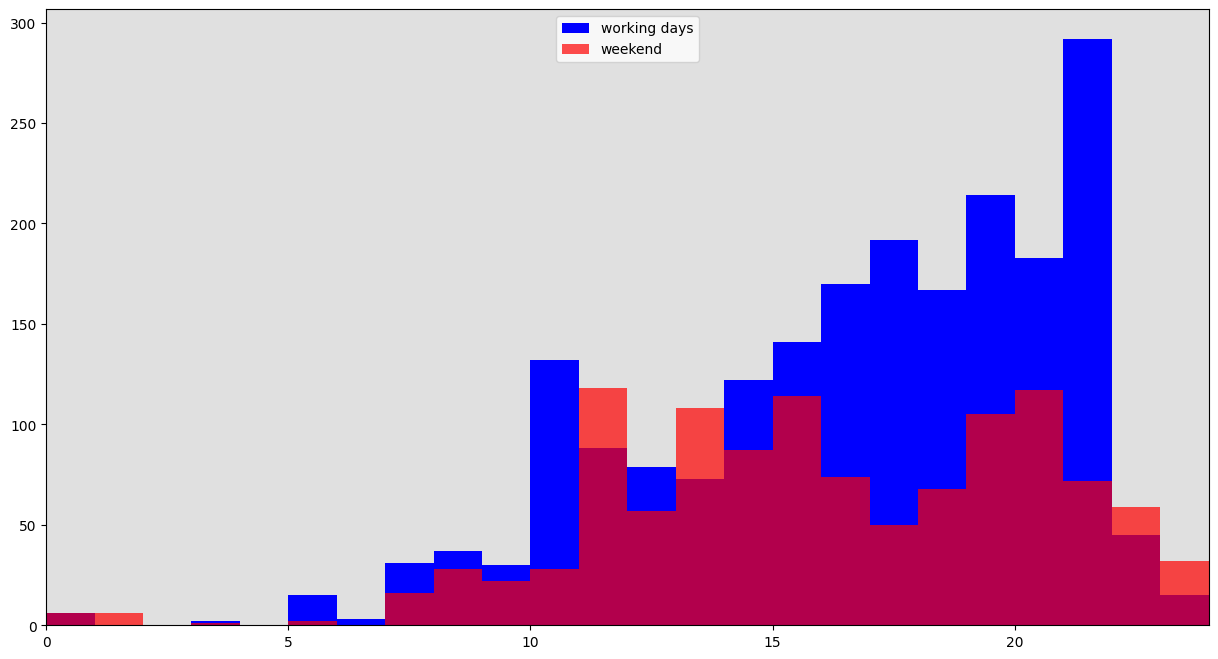

In [441]:
plt.figure(figsize=(15, 8))
bar_width = 1

plt.bar(df.index + bar_width/2, df['working_day'], width=bar_width, label='working days', color='blue')
plt.bar(df.index + bar_width/2, df['weekend'], width=bar_width, label='weekend', color='red', alpha=0.7)

# Настройка внешнего вида
plt.legend()
plt.xlim(0, 24)
plt.style.use('seaborn-v0_8-pastel')
plt.gca().set_facecolor('#e0e0e0')  #  серый фон
plt.show()

### Бывают ли часы, когда общее количество коммитов в выходные дни было выше, чем в рабочие дни?

In [442]:
table_w_w = df[df['weekend'] > df['working_day']]
table_w_w

type,weekend,working_day
hour,,
11,118.0,88.0
13,108.0,73.0
22,59.0,45.0
23,32.0,15.0


#### Закрытие соединения

In [443]:
conn.close()